#UCI ML Drug Review dataset
link: https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018

#Objetivo

Análisis de sentimientos: ¿Qué elementos de la información contenida en la columna ‘review’ la hacen más útil para otros pacientes? ¿Qué pacientes tienden a tener más revisiones negativas? ¿Puede determinar si una review es positiva o negativa?



#Setup

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import torch
from google.colab import drive

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

#Importado el dataset

In [ ]:
!pip install kaggle 

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arturogranados","key":"55059be5f146d7c79b57678f7c5d7d6e"}'}

In [ ]:
!pwd

/content


In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d jessicali9530/kuc-hackathon-winter-2018

 66% 27.0M/40.7M [00:00<00:00, 128MB/s] 
100% 40.7M/40.7M [00:00<00:00, 122MB/s]


# Preprocesamiento de datos

##Exatraccion de los archivos csv

In [ ]:
from zipfile import ZipFile

def open_zipfile(file_name):
  with ZipFile(file_name, 'r') as zip:
    
    zip.printdir()
    zip.extractall()
  

In [ ]:
open_zipfile("kuc-hackathon-winter-2018.zip")

File Name                                             Modified             Size
drugsComTest_raw.csv                           2019-10-11 19:26:30     27637580
drugsComTrain_raw.csv                          2019-10-11 19:26:34     82990470


##Seleccion de columnas

In [ ]:
#lectura de los archivos csv
test_set = pd.read_csv('drugsComTest_raw.csv') 
train_set = pd.read_csv('drugsComTrain_raw.csv')

In [ ]:
# seleccion de los dos columnas de nuestro interes
train_set= train_set[['review', 'rating']]
test_set= test_set[['review', 'rating']]

In [ ]:
train_set.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",9
1,"""My son is halfway through his fourth week of ...",8
2,"""I used to take another oral contraceptive, wh...",5
3,"""This is my first time using any form of birth...",8
4,"""Suboxone has completely turned my life around...",9


In [ ]:
train_set.review[14]

'"Started Nexplanon 2 months ago because I have a minimal amount of contraception&#039;s I can take due to my inability to take the hormone that is used in most birth controls. I&#039;m trying to give it time because it is one of my only options right now. But honestly if I had options I&#039;d get it removed.\r\nI&#039;ve never had acne problems in my life, and immediately broke out after getting it implanted. Sex drive is completely gone, and I used to have sex with my boyfriend a few days a week, now its completely forced and not even fun for me anymore. I mean I&#039;m on birth control because I like having sex but don&#039;t want to get pregnant, why take a birth control that takes away sex? Very unhappy and hope that I get it back with time or I&#039;m getting it removed."'

In [ ]:
train_set.shape

(161297, 2)

In [ ]:
#funcion para pasar de rating a sentimiento
def rating_to_sentiment(rating):
  if rating < 6:
    return 1
  
  else:
    return 0

In [ ]:
#aplicacion de la funcion rating_to_sentiment en el trainset
train_set['rating'] = train_set['rating'].apply(rating_to_sentiment) 

In [ ]:
#aplicacion de la funcion rating_to_sentiment en el testset
test_set['rating'] = test_set['rating'].apply(rating_to_sentiment)

In [ ]:
train_set.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",0
1,"""My son is halfway through his fourth week of ...",0
2,"""I used to take another oral contraceptive, wh...",1
3,"""This is my first time using any form of birth...",0
4,"""Suboxone has completely turned my life around...",0


## Limpieza de texto

In [ ]:
import nltk #importando NLTK(Natural Language Toolkit)
from nltk.corpus import stopwords #importando las stopwords
from nltk.stem.porter import PorterStemmer #importando un stemmer
import re #importando la libreria re
nltk.download("stopwords")#descarga de las stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#funion para limpiar texto
def clean_text(review):
    review = BeautifulSoup(review, "lxml").get_text()
    review = re.sub(r"@[A-Za-z0-9]+", ' ', review)
    review = re.sub(r"https?://[A-Za-z0-9./]+", ' ', review)
    review = re.sub(r"[^a-zA-Z.!?']", ' ', review)
    review = re.sub(r" +", ' ', review)
    return review

In [ ]:
#aplicacion de la funcion clean_text sobre el trainset
train_set['review'] = train_set['review'].apply(clean_text) 

In [ ]:
#aplicacion de la funcion clean_text sobre el trainset
test_set['review'] = test_set['review'].apply(clean_text)

##Conversion a tensores

In [ ]:
#pasando el trainset a un tensor
train_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_set['review'].values, tf.string),
            tf.cast(train_set['rating'].values, tf.int64)
        )
    )
)

In [ ]:
train_set

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#pasando el testset a un tensor
test_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_set['review'].values, tf.string),
            tf.cast(test_set['rating'].values, tf.int64)
        )
    )
)

In [ ]:
test_set

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

##Conversion a PrefetchDataset

In [ ]:
#parametros
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
#conversion de los sets a perfetchdataset
train_dataset = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#Modelo de deep learning

##Capa encoder

In [ ]:
#capa encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

##Modelo 

In [ ]:
#modelo
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
#compilacion del modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
#entrenamiento
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
2521/2521 [==============================] - 167s 57ms/step - loss: 0.4379 - accuracy: 0.7923 - val_loss: 0.3871 - val_accuracy: 0.8250
Epoch 2/15
2521/2521 [==============================] - 121s 48ms/step - loss: 0.3846 - accuracy: 0.8242 - val_loss: 0.3870 - val_accuracy: 0.8323
Epoch 3/15
2521/2521 [==============================] - 118s 47ms/step - loss: 0.3721 - accuracy: 0.8297 - val_loss: 0.3709 - val_accuracy: 0.8260
Epoch 4/15
2521/2521 [==============================] - 117s 46ms/step - loss: 0.3626 - accuracy: 0.8345 - val_loss: 0.3653 - val_accuracy: 0.8354
Epoch 5/15
2521/2521 [==============================] - 117s 47ms/step - loss: 0.3544 - accuracy: 0.8388 - val_loss: 0.3585 - val_accuracy: 0.8354
Epoch 6/15
2521/2521 [==============================] - 116s 46ms/step - loss: 0.3465 - accuracy: 0.8420 - val_loss: 0.3552 - val_accuracy: 0.8333
Epoch 7/15
2521/2521 [==============================] - 116s 46ms/step - loss: 0.3396 - accuracy: 0.8447 - val_loss: 0

In [ ]:
#perdida y accuracy en el test set
test_loss, test_acc = model.evaluate(test_dataset)

841/841 [==============================] - 17s 20ms/step - loss: 0.3290 - accuracy: 0.8553


In [ ]:
import matplotlib.pyplot as plt

#funcion para visualizar el entrenamiento
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

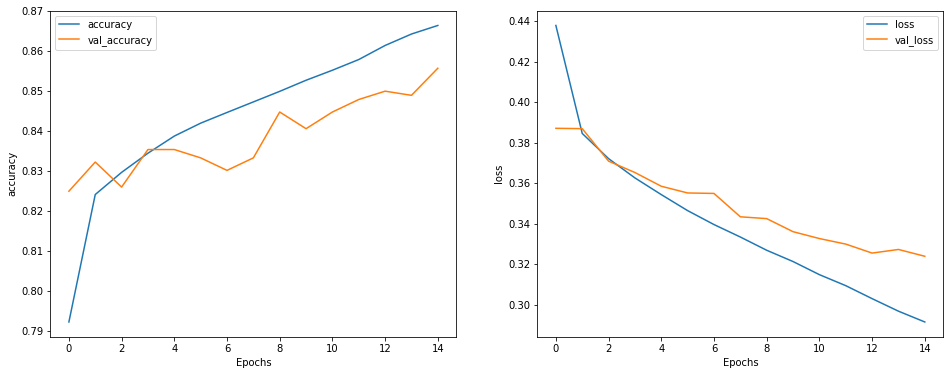

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
y_pred = model.predict(test_dataset)

In [ ]:
def prediccion(array):
  arry = []
  for i in array:
    if  i[0] >= 0:
      arry.append(1)
    else:
      arry.append(0)
  return arry

In [ ]:
y_pred = prediccion(y_pred)

In [ ]:
test = pd.read_csv('drugsComTest_raw.csv') 

In [ ]:
test['rating'] = test['rating'].apply(rating_to_sentiment)

In [ ]:
y_true = list( test['rating'])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_true, y_pred)

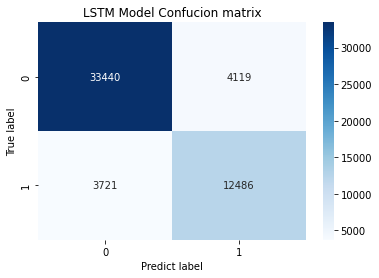

In [ ]:
#matris de confucion
import seaborn as sns
sns.heatmap(confusion_matrix,cmap='Blues', annot=True, fmt="d")
plt.title('LSTM Model Confucion matrix')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

##guardando el model

In [ ]:
import joblib

In [ ]:
joblib.dump(model, 'modelo.pkl')